In [206]:
%reset -f
from rich.progress import track
import pandas as pd
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.warp import Resampling
from rasterio.crs import CRS
from shapely.geometry import mapping
from rasterio.transform import from_origin
from rasterio.mask import mask
import urllib.request
from datetime import date
from datetime import timedelta
import xarray as xr
import rioxarray
from tqdm import tqdm
from requests import get


def read_persiann_css_online0(url, nrow, ncol, dtype=np.int16):
    """Downloads, decompresses a Persiann CCS .bin.gz file, converts it to a NumPy array,
        sets -9999 values to NaN, divides all values by 100, and reshapes to 2x2.

        Args:
            url: The URL of the Persiann CCS .bin.gz file.
            dtype: The desired data type for the NumPy array (default: np.float32).

        Returns:
            A reshaped NumPy array containing the processed data as a nrow*ncol matrix.

        Raises:
            URLError: If an error occurs while downloading the file.
            ValueError: If the decompressed data size is not compatible with nrow*ncol reshape.
    """
    # Try opening the URL and decompressing the data
    try:
        decompressed_data = gzip.decompress(get(url).content)
        # Convert to NumPy array
        data_array = np.frombuffer(decompressed_data, dtype=dtype)
        data_array = data_array.astype(np.float16)
        # Set -9999 values to NaN
        data_array[data_array == -9999] = np.nan
        # Divide all values by 100
        data_array = data_array / 100
        # reshape the array
        data_array=np.reshape(data_array,(nrow,ncol))
        print(f"Data successfully downloaded from {url}")
        return data_array
    except urllib.error.URLError as e:
        raise urllib.error.URLError(f"Error reading file from {url}: {e}")


def read_persiann_css_online(url, nrow, ncol, dtype=np.int16):
    """Downloads, decompresses a Persiann CCS .bin.gz file, converts it to a NumPy array,
       sets -9999 values to NaN, divides all values by 100, and reshapes to 2x2.

    Args:
        url: The URL of the Persiann CCS .bin.gz file.
        nrow: Number of rows for reshaping the data.
        ncol: Number of columns for reshaping the data.
        dtype: The desired data type for the NumPy array (default: np.float32).

    Returns:
        A reshaped NumPy array containing the processed data as a nrow*ncol matrix.

    Raises:
        URLError: If an error occurs while downloading the file.
        ValueError: If the decompressed data size is not compatible with nrow*ncol reshape.
    """

    try:
        # Open the URL, handle unknown content length
        with urllib.request.urlopen(url) as response:
            total_size = int(response.headers.get('content-length', None))  # Get total size (if available)
            progress_bar = tqdm(total=total_size, desc="Downloading data from "+url, unit='B', unit_scale=True, unit_divisor=1024) if total_size is not None else tqdm(desc="Downloading data")

            # Alternative 1: Read data in chunks using read(chunksize)
            compressed_data = b''
            chunksize = 1024*100 # update per 100 kb of downloading
            while True:
                chunk = response.read(chunksize)
                if not chunk:
                    break
                compressed_data += chunk
                if total_size is not None:  # Update progress if total size known
                    progress_bar.update(len(chunk))

            # Alternative 2: Read entire data (if content length is known or for small files)
            # if total_size is not None:
            #     compressed_data = response.read()

            progress_bar.close()  # Close progress bar after download

        # Decompress data
        decompressed_data = gzip.decompress(compressed_data)

        # Convert to NumPy array
        data_array = np.frombuffer(decompressed_data, dtype=dtype)
        data_array = data_array.astype(np.float16)
        # Set -9999 values to NaN
        data_array[data_array == -9999] = np.nan
        # Divide all values by 100
        data_array = data_array / 100
        # reshape the array
        data_array=np.reshape(data_array,(nrow,ncol))
        return data_array
    
    except urllib.error.URLError as e:
        raise urllib.error.URLError(f"Error reading file from {url}: {e}")

def iterate_between_days(start_date, end_date):
  """Iterates through all days between the given start and end date (inclusive).

  Args:
      start_date: The starting date as a datetime.date object.
      end_date: The ending date as a datetime.date object.

  Yields:
      A datetime.date object for each day between the start and end date (inclusive).
  """

  # Ensure start date is less than or equal to end date
  if start_date > end_date:
    raise ValueError("Start date must be less than or equal to end date.")

  current_date = start_date
  while current_date <= end_date:
    yield current_date
    current_date += timedelta(days=1)

def format_number_with_zeros(number, desired_digits):
  """Formats a number with leading zeros to reach the desired number of digits.

  Args:
      number: The integer to format.
      desired_digits: The desired number of digits in the output string.

  Returns:
      A string representation of the number with leading zeros if needed.
  """

  if not isinstance(number, int) or desired_digits <= 0:
    raise ValueError("Invalid input: number must be an integer and desired_digits must be positive.")

  # Convert the number to a string
  number_str = str(number)

  # Add leading zeros if needed
  num_leading_zeros = desired_digits - len(number_str)
  formatted_string = "0" * num_leading_zeros + number_str

  return formatted_string

def iter_url(start_year, start_month, start_day, end_year, end_month, end_day, interval):
    """
    Generates a set of URLs based on the given parameters and date range.

    Args:
        start_year: The starting year of the date range.
        start_month: The starting month of the date range.
        start_day: The starting day of the date range.
        end_year: The ending year of the date range.
        end_month: The ending month of the date range.
        end_day: The ending day of the date range.
        interval: The interval between URLs in hours (e.g., 3 for every 3 hours).

    Returns:
        A set containing all generated URLs.
    """

    # Validate input (optional)
    # ... (add checks for valid date range, interval, etc., if needed)
    # Define the time range for the dataset's dimension of time
    start_time = pd.Timestamp(year=start_year, month=start_month, day=start_day)
    end_time = pd.Timestamp(year=end_year, month=end_month, day=end_day, hour=23, minute=59, second=59)
    freq=str(interval)+'h'
    
    start_date = start_time.date()
    end_date = end_time.date()
    
    url_base = "https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/"
    # Initialize an empty set to store URLs
    urls = []
    for day in iterate_between_days(start_date, end_date):
        doy = day.timetuple().tm_yday  # Day of the year
        year_2d = str(day.year)[-2:]  # Last two digits of the year
        doy_formatted = format_number_with_zeros(doy, 3)
        for hh in range(0, 24, interval):
            hh_formatted = format_number_with_zeros(hh, 2)  # Hour with leading zeros
            # Construct the URL and add it to the set
            url = url_base + str(interval) + "hrly/" + "rgccs" + freq + year_2d + doy_formatted + hh_formatted + '.bin.gz'
            urls.append(url)
    
    
    time_range = pd.date_range(start=start_time, end=end_time, freq=freq, inclusive="left")
    time_range=xr.Variable(dims='time',data=time_range)

    print(f"{len(urls)} datasets from {start_date} to {end_date} with a frequency of {freq} will be downloaded from {url_base}")
    return urls, time_range

def download_geopackage(url, filename="temp.gpkg"):
  """
  Downloads a geopackage file from a URL.

  Args:
      url: The URL of the online geopackage file.
      filename: Temporary filename to store the downloaded geopackage (optional).

  Returns:
      The filename of the downloaded geopackage.
  """
  # Download the geopackage file
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(filename, 'wb') as f:
      for chunk in response.iter_content(1024):
        f.write(chunk)
    print(f"Succeeded in downloading geopackage from {url}")
    return filename
  else:
    raise ValueError(f"Failed to download geopackage from {url}")

def clip_data(np_data, shape_esm):
    """
    Clips the DataArray 'data' using the geometry from 'shape_esm'.

    Args:
        np_data (xr.DataArray): The DataArray to clip.
        shape_esm (geopandas.GeoDataFrame): GeoDataFrame containing the geometry to clip with.

    Returns:
        xr.DataArray: The clipped DataArray.
    """

    lat = np.arange(60, -60, -0.04)  # 3000 rows
    lon = np.arange(-180, 180, 0.04)  # 9000 cols

    data = xr.DataArray(data=np_data, dims=["lat", "lon"], coords=[lat, lon])
    data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data.rio.write_crs("epsg:4326", inplace=True)

    data_esm = data.rio.clip(shape_esm.geometry.apply(mapping), shape_esm.crs, all_touched=True)

    return data_esm 

def clip_array_with_geopackage(data, filename, crs=None):
  """
  Clips a NumPy array using a geopackage file.

  Args:
      data: The NumPy array to clip.
      filename: Path to the geopackage file.
      crs: Coordinate Reference System (CRS) of the data and shapefile (optional).

  Returns:
      A NumPy array representing the clipped data.
  """

  # Read the shapefile
  gdf = gpd.read_file(filename)

  # Get the first geometry (assuming only one shape is needed)
  geometry = mapping(gdf.iloc[0].geometry)

  # Open the raster dataset from the NumPy array
  with rasterio.open(None, "w", driver="GTiff", height=data.shape[0], width=data.shape[1], count=1, dtype=data.dtype) as src:
    src.transform = rasterio.Affine.identity  # Assuming unit transform for simplicity
    src.crs = crs if crs else CRS.from_epsg(4326)  # Default to EPSG:4326 (WGS84)
    src.write(data, 1)

    # Clip the raster by the geometry
    clipped, transform = rasterio.rasterize(shapes=[geometry], out_shape=data.shape, fill=0, transform=src.transform, crs=src.crs, resampling=Resampling.nearest)

  # Cleanup (optional, remove downloaded file after use)
  # import os
  # if os.path.exists(filename):
  #   os.remove(filename)

  return clipped

def read_persiann_ccs(file_path):
    ncols, nrows = 9000, 3000
    data = np.zeros((nrows, ncols), dtype=np.float32)  # Initialize data array

    with gzip.open(file_path, 'rb') as f:
        for i in range(nrows):
            for j in range(ncols):
                # Read two bytes from the file, big-endian format
                val = struct.unpack('>h', f.read(2))[0]
                # Convert to mm/3hr, handling the no-data value
                data[i, j] = np.nan if val == -9999 else val / 100.0

    return data
# return a numpy array
def convert_to_geotiff(data, geotiff_path):
    transform = from_origin(-180, 60, 0.04, 0.04)
    metadata = {
        'driver': 'GTiff',
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1,
        'dtype': 'float32',
        'crs': '+proj=latlong',
        'transform': transform
    }
    
    with rasterio.open(geotiff_path, 'w', **metadata) as dst:
        dst.write(data, 1)

def clip_raster_with_gpkg(raster_path, gpkg_path, clipped_raster_path):
    gdf = gpd.read_file(gpkg_path)
    gdf = gdf.to_crs(crs='+proj=latlong')
    
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        
        out_meta.update({
            'driver': 'GTiff',
            'height': out_image.shape[1],
            'width': out_image.shape[2],
            'transform': out_transform
        })
        
        with rasterio.open(clipped_raster_path, 'w', **out_meta) as dest:
            dest.write(out_image)

# def plot_clipped_data(clipped_raster_path):
#     with rasterio.open(clipped_raster_path) as src:
#         data = src.read(1)
#         plt.figure(figsize=(12, 6))
#         plt.imshow(data, cmap='viridis', origin='upper')
#         plt.colorbar(label='Precipitation (mm/3hr)')
#         plt.title('Clipped PERSIANN-CCS Precipitation')
#         plt.xlabel('Longitude')
#         plt.ylabel('Latitude')
#         plt.show()

def plot_clipped_data(clipped_raster_array):
    plt.figure(figsize=(12, 6))
    plt.imshow(clipped_raster_array, cmap='viridis', origin='upper')
    plt.colorbar(label='Precipitation (mm/3hr)')
    plt.title('Clipped PERSIANN-CCS Precipitation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# # Paths
# file_path = "C:/Users/liang.yang/Downloads/rgccs3h0300100.bin.gz"
# geotiff_path = '/home/hidrologia/Downloads/rgccs3h0300100.tif'
# gpkg_path = '/home/hidrologia/Pronostico_hidro/Inputs/Manduriacu_delimitada.gpkg'
# clipped_raster_path = '/home/hidrologia/Downloads/clipped_rgccs3h0300100.tif'

# # Read and convert the data to GeoTIFF
# data = read_persiann_ccs(file_path)
# convert_to_geotiff(data, geotiff_path)

# # Clip the GeoTIFF with the geopackage shapefile
# clip_raster_with_gpkg(geotiff_path, gpkg_path, clipped_raster_path)

# # Plot the clipped data
# plot_clipped_data(clipped_raster_path)


In [188]:
nrow = 3000
ncol = 9000 # As per the readme file of the raw dataset
start_year=2023
start_month=1
start_day=1
end_year=2023
end_month=1
end_day=1
interval=6 # choose from 3 and 6
shape_file_url = "https://github.com/DPAINAMHI/esmeraldas/raw/bba2fdfc0fa2098b99d9e106f4775cc42b56de8a/Basins/esmeraldas.gpkg"

# Get the list of URLs and desired time range of data
ccs_urls, time_range = iter_url(start_year,start_month,start_day,end_year,end_month,end_day,interval)
# Download the shape file of Esmeraldas from the github repo
shape_file = download_geopackage(shape_file_url)
shape_file=gpd.read_file(shape_file)

array_list=[] # Null container of all the clipped array
for i, url in enumerate(ccs_urls):
    try:
        array_esm_temp = clip_data(read_persiann_css_online0(url, nrow, ncol), shape_file)
        array_list.append(array_esm_temp)
        print(f"Succeeded in storing data of {time_range[i].values} \n{i+1} of {len(ccs_urls)} downloaded")
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
dataset = xr.concat(array_list, dim=time_range)
dataset = dataset.drop_vars('spatial_ref')
data_dict = {"precipitation": dataset}
ds = xr.Dataset(data_dict)
ds=ds.astype(np.float32)

output_filename = "clipped_arrays.nc"
ds.to_netcdf(output_filename)
print(f"Clipped arrays saved to: {output_filename}")

4 datasets from 2023-01-01 to 2023-01-01 with a frequency of 6h will be downloaded from https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/
Succeeded in downloading geopackage from https://github.com/DPAINAMHI/esmeraldas/raw/bba2fdfc0fa2098b99d9e106f4775cc42b56de8a/Basins/esmeraldas.gpkg


Succeeded in storing data of 2023-01-01T00:00:00.000000000 
1 of 4 downloaded


Succeeded in storing data of 2023-01-01T06:00:00.000000000 
2 of 4 downloaded


Succeeded in storing data of 2023-01-01T12:00:00.000000000 
3 of 4 downloaded


Succeeded in storing data of 2023-01-01T18:00:00.000000000 
4 of 4 downloaded
Clipped arrays saved to: clipped_arrays.nc


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
ds.isel(ds.precipitation.argmax(...)) # Method for conditional selecting
ds.precipitation[0].data # Method for slicing or indexing, never use .values

In [190]:
c=ds.precipitation[0].data

In [148]:
# Debug the clip_array_with_geopackage function
ccs_url="https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/6hrly/rgccs6h2300100.bin.gz"
data=read_persiann_css_online0(ccs_url,3000,9000)

Data successfully downloaded from https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/6hrly/rgccs6h2300100.bin.gz


In [149]:
clipped=clip_data(data,shape_esm)

In [152]:
b=clipped.values
b

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float16)

In [ ]:
lat=np.arange(60,-60,-0.04) # 3000 rows
lon=np.arange(-180,180,0.04) # 9000 cols
data = xr.DataArray(data=data, dims=["lat", "lon"], coords=[lat,lon])
data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data.rio.write_crs("epsg:4326", inplace=True)
data_esm = data.rio.clip(shape_esm.geometry.apply(mapping),shape_esm.crs,all_touched=True)

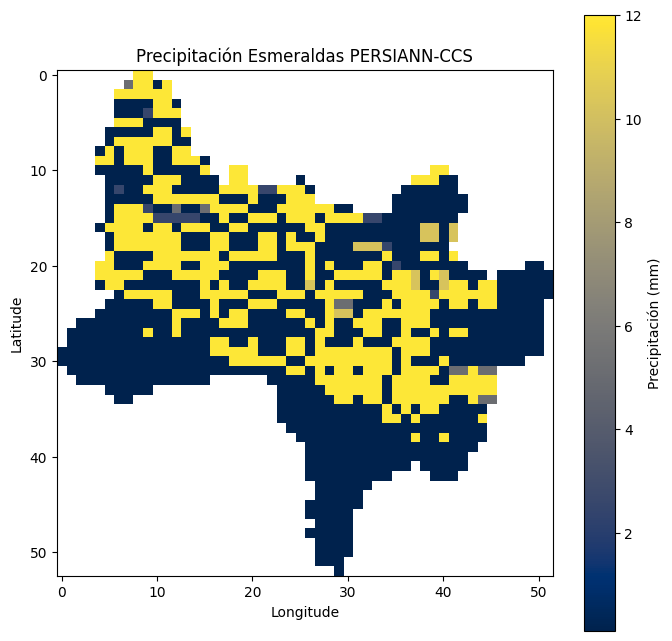

In [154]:

fig = plt.subplots(figsize=(8,8))
plt.imshow(clipped,cmap='cividis',vmin=0.1,vmax=12)
plt.title("Precipitación Esmeraldas PERSIANN-CCS")
plt.colorbar(label='Precipitación (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [204]:
def read_css_local0(item):
    f = gzip.GzipFile(item) # item is the local dic of the .bin.gz file
    file_content = f.read()
    data = np.frombuffer(file_content, dtype=np.dtype('>h')).astype(float) 
    data = data.reshape((3000,9000))
    data_1 = data[:,4500:]
    data_2 = data[:,:4500]
    data = np.hstack((data_1,data_2))
    data= data/100
    data[data < 0] = np.nan
    data = np.flipud(data)
    return data

def read_persiann_css_online1(url, nrow, ncol):
    try:
        decompressed_data = gzip.decompress(get(url).content)
        # Convert to NumPy array
        data = np.frombuffer(decompressed_data, dtype=np.dtype('>h')).astype(float) 
        data = data.reshape((3000,9000))
        data_1 = data[:,4500:]
        data_2 = data[:,:4500]
        data = np.hstack((data_1,data_2))
        data= data/100
        data[data < 0] = np.nan
        data = np.flipud(data)
        print(f"Data successfully downloaded from {url}")
        return data
    except urllib.error.URLError as e:
        raise urllib.error.URLError(f"Error reading file from {url}: {e}")

In [193]:
item = "C:/Users/liang.yang/Downloads/rgccs6h2300100.bin.gz"
shape_esm=gpd.read_file('C:/Users/liang.yang/Desktop/esmeraldas/Basins/esmeraldas.gpkg')
d1=read_css_local0(item)
lat=np.arange(60,-60,-0.04) # 3000 rows
lon=np.arange(-180,180,0.04) # 9000 cols
data = xr.DataArray(data=d1, dims=["lat", "lon"], coords=[lat,lon])
data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data.rio.write_crs("epsg:4326", inplace=True)
data_esm_1 = data.rio.clip(shape_esm.geometry.apply(mapping),shape_esm.crs,all_touched=True)

In [196]:
a=data_esm_1.data


In [205]:
d2=read_persiann_css_online1('https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/6hrly/rgccs6h2300100.bin.gz',3000,9000)
data_esm_2=clip_data(d2,shape_esm)
b=data_esm_2.data

Data successfully downloaded from https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/6hrly/rgccs6h2300100.bin.gz


In [189]:
a=data_esm_1.values
b=data_esm_2.values

fig = plt.subplots(figsize=(8,8))
plt.imshow(data_esm_1,cmap='cividis',vmin=0.1,vmax=12)
plt.title("Precipitación Esmeraldas PERSIANN-CCS")
plt.colorbar(label='Precipitación (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


fig = plt.subplots(figsize=(8,8))
plt.imshow(data_esm_2,cmap='cividis',vmin=0.1,vmax=12)
plt.title("Precipitación Esmeraldas PERSIANN-CCS")
plt.colorbar(label='Precipitación (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

NameError: name 'data_esm_1' is not defined